# Συσταδοποίηση βάσει μόνο οργάνων και παθήσεων

In [11]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords') 
from nltk.corpus import stopwords
import string
import spacy
import el_core_news_md
nlp = el_core_news_md.load()
from greek_stemmer import GreekStemmer
stemmer = GreekStemmer()
import re

total_stop_words = (nlp.Defaults.stop_words).union(set(stopwords.words('greek')))
total_stop_words = total_stop_words.union({'ή', 'μόνον'})
total_puncts = string.punctuation + '«»–“”\xa0‘•…●\uf0b7◗♥.'
total_stop_words = list(total_stop_words) + list(string.punctuation)
#total_stop_words += [stemming(word) for word in total_stop_words]
import warnings
warnings.filterwarnings('ignore')


def texts_retrieval(data_filename):
    df_texts = pd.read_csv(data_filename, index_col=None)
    return df_texts['text']



def sentences_retrieval(texts):
    documents = []
    for text in texts:
        documents += nltk.sent_tokenize(text)
    final_documents = []
    for j in range(len(documents)):   
        if re.search(r'[.!;][Α-ΩA-Z"«“]', documents[j]) != None :
            sents = re.split(r'([.!;][Α-ΩA-Z"«“])', documents[j])
            sentences = []
            for i in range(len(sents)):
                if i == 0:
                    sentences.append(sents[i])
                elif i%2 == 0:
                     sentences.append(sents[i-1][1] + sents[i])
            for sentence in sentences:
                if len(sentence)>3:
                    final_documents.append(sentence)
        else:
            if len(documents[j])>3:
                final_documents.append(documents[j])
        
    return final_documents



def filter_punctuation(words):
    filtered_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in total_puncts)

        if not all(pun):
            word = word.strip(total_puncts)
            
            if (len(word)>3):
                for punct in total_puncts:
                    word = word.replace(punct, ' ')
            else:
                for punct in total_puncts:
                    word = word.replace(punct, '')
                    
            tokens = nltk.word_tokenize(word)
            
            for token in tokens:
                filtered_words.append(token)
                
    return filtered_words



def group_numbers(words):
    new_words = []
    for word in words:
        if re.fullmatch(r'[0-9]+', word) != None :
            if int(word) >= 1800 and int(word) <= 2020:
                word = '2000'
            else:
                word = '1'
        new_words.append(word)
    return new_words



def removing_accents(word):
    """
    Removes accents from a given word.
    
    Parameters
    ----------
    word : str
        the word from which we want to remove the accents

    Returns
    -------
    str
        the word without accents
    """
    return (word.replace('ά', 'α').replace('έ', 'ε').replace('ή', 'η').replace('ί', 'ι').replace('ό', 'ο').replace('ύ', 'υ')
            .replace('ώ', 'ω').replace('ϊ', 'ι').replace('ϋ', 'υ').replace('ΐ', 'ι').replace('ΰ', 'υ'))



def stemming(word):
    """
    Implements stemming for a given word.
    
    Parameters
    ----------
    word : str
        the word that is about to be stemmed

    Returns
    -------
    str
        the stem of the given word at uppercase letters
    """
    return stemmer.stem((removing_accents(word)).upper())

def keep_features_relevant_to_organs(stopwords, filename, encoding):
    with open(filename,'r',encoding=encoding) as f:
        content = f.readlines()
    content = [x.strip() for x in content] 
    for term in content:
        extra_stop_words = term.split(',')
    stopwords += extra_stop_words
    
    return stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
texts = texts_retrieval('../data/votana_total_texts_annotated.csv')
documents = sentences_retrieval(texts)

In [13]:
len(documents)

41549

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
stop_words = set(keep_features_relevant_to_organs(total_stop_words, '../data/expanded_stopwords.txt', 'utf-8'))
tokenized_stop_words = nltk.word_tokenize(' '.join(keep_features_relevant_to_organs(total_stop_words, '../data/expanded_stopwords.txt', 'utf-8')))

class Tokenizer(object):
    def __init__(self):
        nltk.download('punkt', quiet=True, raise_on_error=True)
        self.stemmer = GreekStemmer()
        
    def _stem(self, token):
        if (token in stop_words):
            return token
        return self.stemmer.stem((removing_accents(token)).upper())
        
    def __call__(self, line):
        tokens = nltk.word_tokenize(line)
        tokens = filter_punctuation(list(tokens))
        tokens = group_numbers(tokens)
        tokens = (self._stem(token) for token in tokens)
        return tokens
    

vectorizer = TfidfVectorizer(max_df=0.5, min_df=6, stop_words=tokenized_stop_words, tokenizer=Tokenizer())
tf_idf_array = vectorizer.fit_transform(documents)

In [4]:
from joblib import dump, load

In [6]:
dump(tf_idf_array, 'tfidf_array2.joblib')

['tfidf_array2.joblib']

In [5]:
tf_idf_array = load('tfidf_array2.joblib') 

In [1]:
#print(vectorizer.stop_words_)

In [2]:
#print(vectorizer.get_feature_names())

In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(13, 203):
    km = KMeans(k, max_iter=10000)
    preds = km.fit_predict(tf_idf_array)
    silhouette_scores.append(silhouette_score(tf_idf_array, preds))

Maximum average silhouette score for k = 202


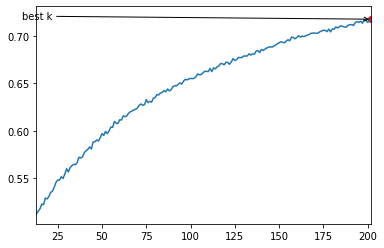

In [24]:
import matplotlib.pyplot as plt
plt.plot(range(13, 203), silhouette_scores)
best_k = np.argmax(silhouette_scores) + 13
plt.scatter(best_k, silhouette_scores[best_k-13], color='r') 
plt.xlim([13,202])
plt.annotate("best k", xy=(best_k, silhouette_scores[best_k-13]), xytext=(5, silhouette_scores[best_k-13]),arrowprops=dict(arrowstyle="->")) 
print('Maximum average silhouette score for k =', best_k)

In [25]:
km = KMeans(best_k)
km.fit(tf_idf_array)
print(km.labels_)

[ 5  1 90 ...  1  1  1]


In [13]:
from joblib import dump, load

In [16]:
dump(km, 'kmeans2.joblib') 

['kmeans2.joblib']

In [6]:
km = load('kmeans2.joblib') 

In [7]:
km.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 102,
 'n_init': 10,
 'n_jobs': None,
 'precompute_distances': 'auto',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [108]:
df_docs = pd.read_csv('../data/properties.csv')
df_docs['Organs Cluster'] = km.labels_
df_docs.to_csv('../data/properties.csv', index=False)

In [3]:
#for i in range(len(km.labels_)):
#    if km.labels_[i] == 101:
#        print('~')
#        print(documents[i])

In [16]:
terms = vectorizer.get_feature_names()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(102):
    out = "Cluster %d:" % i
    for ind in order_centroids[i, :10]:
        out += ' %s' % terms[ind]
    print(out)

Cluster 0: ΑΙΜΟΡΡΟΙΔ ΑΝΑΙΜ ΘΥΜ ΠΟΝΟΛΑΙΜ ΟΣΤ ΜΗΤΡ ΑΜΥΝ ΣΕΞΟΥΑΛ ΛΙΜΠΙΝΤ ΟΥΡΟΔΟΧ
Cluster 1: ΜΑΛΛ ΤΡΙΧΟΠΤΩΣ ΔΕΡΜ ΠΙΤΥΡΙΔ ΤΡΙΧ ΛΙΠΑΡΟΤΗΤ ΝΕΦΡ ΜΑΤ ΑΝΑΙΜ ΑΙΜΟΣΤΑΤ
Cluster 2: ΣΤΟΜ ΣΤΟΜΑΧ ΜΥΤ ΒΡΟΓΧΙΤΙΔ ΛΑΡΥΓΓ ΚΑΟΥΡ ΟΣΜ ΙΛΑΡ ΜΑΤ ΧΕΙΛ
Cluster 3: ΑΝΟΣΟΠΟΙΗΤ ΑΜΥΝ ΜΗΤΡ ΕΝΤΕΡ ΑΝΟΣ ΘΥΜ ΝΕΥΡ ΑΝΤΙΣΩΜ ΑΝΤΙΚΑΤΑΡΡΟΙΚ ΑΙΜΟΠΕΤΑΛ
Cluster 4: ΗΡΕΜΙΣΤ ΝΕΥΡ ΥΠΟΤΑΣ ΥΠΝΩΤ ΠΟΝΟΚΕΦΑΛ ΔΙΟΥΡΗΤ ΚΑΡΔ ΜΥΟΧΑΛΑΡΩΤ ΝΕΥΡΙΚΟΤΗΤ ΕΓΚΕΦΑΛ
Cluster 5: ΣΤΟΜΑΧ ΚΟΙΛΙΑΚ ΓΑΣΤΡΙΤΙΔ ΜΕΤΕΩΡΙΣΜ ΝΕΥΡΩΣ ΚΑΡΔΙΑΛΓ ΕΛΚ ΟΙΣΟΦΑΓ ΔΩΔΕΚΑΔΑΚΤΥΛ ΑΙΜ
Cluster 6: ΜΑΤ ΚΡΙΘΑΡΑΚ ΕΠΙΠΕΦΥΚΙΤΙΔ ΟΦΘΑΛΜ ΩΧΡ ΔΕΡΜ ΓΛΑΥΚΩΜ ΑΜΦΙΒΛΗΣΤΡΟΕΙΔ ΣΠΛΗΝ ΑΝΟΣΟΠΟΙΗΤ
Cluster 7: ΑΝΟΣΟΠΟΙΗΤ ΑΙΜ ΚΥΚΛΟΦΟΡ ΠΕΨ ΑΘΗΡΟΣΚΛΗΡΩΣ ΕΜΜΗΝΟΠΑΥΣ ΚΑΡΔΙΑΚ ΠΝΕΥΜΟΝ ΠΗΞ ΜΥ
Cluster 8: ΕΓΚΕΦΑΛ ΝΕΥΡ ΟΡΧ ΑΙΜ ΚΥΚΛΟΦΟΡ ΝΕΥΡΟΔΙΑΒΙΒΑΣΤ ΑΓΓΕΙ ΓΛΟΙΩΜ ΑΝΟΣΟΠΟΙΗΤ ΚΑΡΔ
Cluster 9: ΕΝΤΕΡ ΣΤΟΜΑΧ ΔΙΟΥΡΗΤ ΚΟΛΙΤΙΔ ΑΙΜ ΜΥ ΕΜΜΗΝΑΓΩΓ ΕΛΚΩΔ ΘΥΜ ΚΟΙΛ
Cluster 10: ΣΥΚΩΤ ΝΕΦΡ ΑΙΜ ΔΙΟΥΡΗΤ ΚΑΡΔ ΣΤΟΜΑΧ ΕΝΤΕΡ ΧΟΛΗΔΟΧ ΟΥΡΟΔΟΧ ΣΠΛΗΝ
Cluster 11: ΝΕΥΡ ΧΑΛΑΡΩΝ ΧΑΛΑΡΩΣ ΣΤΟΜΑΧ ΑΠΟΛΗΞ ΚΝΣ ΝΕΥΡΑΛΓ ΕΓΚΕΦΑΛ ΑΙΜ ΘΥΜ
Cluster 12: ΑΙΜ ΠΗΞ ΛΙΠΙΔ